In [27]:
import pandas as pd
import numpy as np
import pywt
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import re
from sklearn.metrics import confusion_matrix

from collections import Counter


In [28]:
annotation_classes_map = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'V': 'Premature ventricular contraction',
    '/': 'Paced beat',
    'f': 'Fusion of paced and normal beat',
}

In [29]:
# Function to remove baseline wander using DWT
def remove_baseline_wander(signal, wavelet="db4", level=8):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[-1] = np.zeros_like(coeffs[-1])
    return pywt.waverec(coeffs, wavelet)

# Function to smooth signal using Savitzky-Golay filter
def smooth_signal(signal, window_length=11, polyorder=3):
    return savgol_filter(signal, window_length, polyorder)

# Function to segment the ECG signal around the R-peaks
def segment_ecg_signal(ecg_signal, annotations_df, r_peak_offset=100, segment_length=251):
    segments = []
    for _, row in annotations_df.iterrows():
        r_peak = row['Sample #']
        start = max(r_peak - r_peak_offset, 0)  # ensure start is not negative
        end = min(start + segment_length, len(ecg_signal))  # ensure end does not go past the signal length
        segment = ecg_signal[start:end]
        if len(segment) == segment_length:  # only append if the segment is the correct length
            segments.append(segment)
    return segments

# Function to extract features using DWT
def extract_dwt_features(segments, wavelet='db2', level=4):
    features = []
    for segment in segments:
        coeffs = pywt.wavedec(segment, wavelet, level=level)
        # Only use the approximation coefficients at the given level
        features.append(coeffs[0])
    return features

def parse_annotations(annotations):
    annotation_pattern = re.compile(r'\s*(\d+:\d+\.\d+)\s+(\d+)\s+(\S+)\s+(\d+)\s+(\d+)\s+(\d+)\s*(\(.*\))?')
    parsed_annotations = []
    for line in annotations:
        match = annotation_pattern.match(line)
        if match:
            time, sample_number, annotation_type, sub, chan, num, aux = match.groups()
            # Map the annotation type to your classes of interest, or 'Other' if not found
            annotation_type_mapped = annotation_type if annotation_type in annotation_classes_map else 'Other' 
            parsed_annotations.append((time, int(sample_number), annotation_type_mapped, int(sub), int(chan), int(num), aux))
    return pd.DataFrame(parsed_annotations, columns=['Time', 'Sample #', 'Type', 'Sub', 'Chan', 'Num', 'Aux'])

In [30]:
train_patient_ids = ['100', '104', '108', '117', '201', '207', '212', '217', '222', '231', '101', '114', '123', '208', '213', '219', '223', '232', '102', '106', '119', '124', '203', '209', '214', '228', '233', '103', '107', '112', '116', '121', '200', '205', '210', '215', '221', '230', '234']

# Initialize empty lists to hold the aggregated features and labels
all_features = []
all_labels = []

beat_type_counter = Counter()

for patient_id in train_patient_ids:
    # Load the ECG data and annotations for each patient
    with open(f'./datasets/{patient_id}annotations.txt', 'r') as file:
        annotations = file.readlines()
        
    ecg_data = pd.read_csv(f'./datasets/{patient_id}.csv')
    annotations_df = parse_annotations(annotations)
    
    # Sampling rate and duration for 5 minutes
    sampling_rate = 360  # samples per second for MIT-BIH
    duration = 5 * 60  
    num_samples = duration * sampling_rate

    ecg_data.columns = ecg_data.columns.str.strip("'")

    start_sample = 0  
    ecg_portion = ecg_data.iloc[start_sample:start_sample + num_samples].copy()
    ecg_portion['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion['MLII'])
    ecg_portion['ECG_smoothed'] = smooth_signal(ecg_portion['ECG_baseline_removed'])

    # Filter annotations to only include those within the 5-minute window
    annotations_portion = annotations_df[(annotations_df['Sample #'] >= start_sample) & 
                                        (annotations_df['Sample #'] < start_sample + num_samples)]
    ecg_segments = segment_ecg_signal(ecg_portion['ECG_smoothed'], annotations_portion)
    ecg_features = extract_dwt_features(ecg_segments)

    feature_matrix_patient = np.array(ecg_features)
    labels_patient = annotations_portion['Type'].values[:len(ecg_features)]  # Ensuring labels align with the segments

    # Append the features and labels to the aggregate lists
    all_features.append(feature_matrix_patient)
    all_labels.append(labels_patient)
    beat_type_counter.update(labels_patient)

# Combine all features and labels into single arrays
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

print(beat_type_counter)

Counter({'N': 10737, 'V': 1107, '/': 1092, 'R': 1016, 'Other': 991, 'L': 420, 'f': 159})


In [31]:
desired_counts = {
    'N': 850,
    'L': 500,
    'R': 850,
    'f': 150,
    'V': 300,
    '/': 550
}

balanced_features = []
balanced_labels = []

# For each beat type, balance according to the desired count
for beat_type, count in desired_counts.items():
    # Find the indices of the current beat type
    indices = np.where(all_labels == beat_type)[0]

    if beat_type_counter[beat_type] > count:
        # Downsample if there are more than the desired count
        chosen_indices = np.random.choice(indices, count, replace=False)
    else:
        # Upsample if there are fewer than the desired count
        # Note: This is only advisable if you have a method to add variance to the data or if replicating data is acceptable
        chosen_indices = np.random.choice(indices, count, replace=True)

    # Append the balanced data
    balanced_features.append(all_features[chosen_indices])
    balanced_labels.append(all_labels[chosen_indices])

# Combine all balanced data into single arrays
balanced_features = np.vstack(balanced_features)
balanced_labels = np.concatenate(balanced_labels)

#all_features = balanced_features
#all_labels = balanced_labels
# Confirm the balancing
print(Counter(balanced_labels))


Counter({'N': 850, 'R': 850, '/': 550, 'L': 500, 'V': 300, 'f': 150})


In [32]:
test_patient_ids = ['105', '109', '111', '113', '115', '118', '122', '202', '220']

for test_patient_id in test_patient_ids:
    with open(f'./datasets/{test_patient_id}annotations.txt', 'r') as file:
        annotations = file.readlines()
    
    ecg_test_data = pd.read_csv(f'./datasets/{test_patient_id}.csv')
    annotations_test_df = parse_annotations(annotations)
    ecg_test_data.columns = ecg_test_data.columns.str.strip("'")

    # Sampling rate and duration for 5 minutes
    sampling_rate = 360  # samples per second for MIT-BIH
    duration = 5 * 60  # 5 minutes in seconds
    num_samples = duration * sampling_rate

    start_sample = 0  
    ecg_test_portion = ecg_test_data.iloc[start_sample:start_sample + num_samples].copy()
    ecg_test_portion['ECG_baseline_removed'] = remove_baseline_wander(ecg_test_portion['MLII'])
    ecg_test_portion['ECG_smoothed'] = smooth_signal(ecg_test_portion['ECG_baseline_removed'])

    # Filter annotations to only include those within the 5-minute window
    annotations_test_portion = annotations_test_df[(annotations_test_df['Sample #'] >= start_sample) & 
                                        (annotations_test_df['Sample #'] < start_sample + num_samples)]

    ecg_test_segments = segment_ecg_signal(ecg_test_portion['ECG_smoothed'], annotations_test_portion)
    ecg_test_features = extract_dwt_features(ecg_test_segments)

    feature_matrix_test = np.array(ecg_test_features)
    labels_test_patient = annotations_test_portion['Type'].values[:len(ecg_test_features)]  # Ensuring labels align with the segments
    
    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(all_features)
    X_test_scaled = scaler.transform(feature_matrix_test)

    svm_classifier = SVC(kernel='rbf', gamma='auto', class_weight='balanced')

    svm_classifier.fit(X_train_scaled, all_labels)

    # Prediction and evaluation
    y_pred = svm_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(labels_test_patient, y_pred)
    print("---------------------------------------------------")
    print(f'Accuracy for patient {test_patient_id}: {accuracy}')

    # Generate the classification report for patient 109's data
    classification_rep_test = classification_report(labels_test_patient, y_pred, labels=np.unique(labels_test_patient), 
                                                target_names=[annotation_classes_map.get(label, 'Other') for label in np.unique(labels_test_patient)], 
                                                zero_division=0)

    print(classification_rep_test)


---------------------------------------------------
Accuracy for patient 105: 0.9458823529411765
                                   precision    recall  f1-score   support

                      Normal beat       0.98      0.97      0.97       404
                            Other       0.53      1.00      0.69         9
Premature ventricular contraction       0.67      0.17      0.27        12

                        micro avg       0.95      0.95      0.95       425
                        macro avg       0.72      0.71      0.64       425
                     weighted avg       0.96      0.95      0.95       425

---------------------------------------------------
Accuracy for patient 109: 0.009237875288683603
                                   precision    recall  f1-score   support

    Left bundle branch block beat       0.00      0.00      0.00       424
                            Other       0.00      0.00      0.00         3
Premature ventricular contraction       0.03      

# Plots

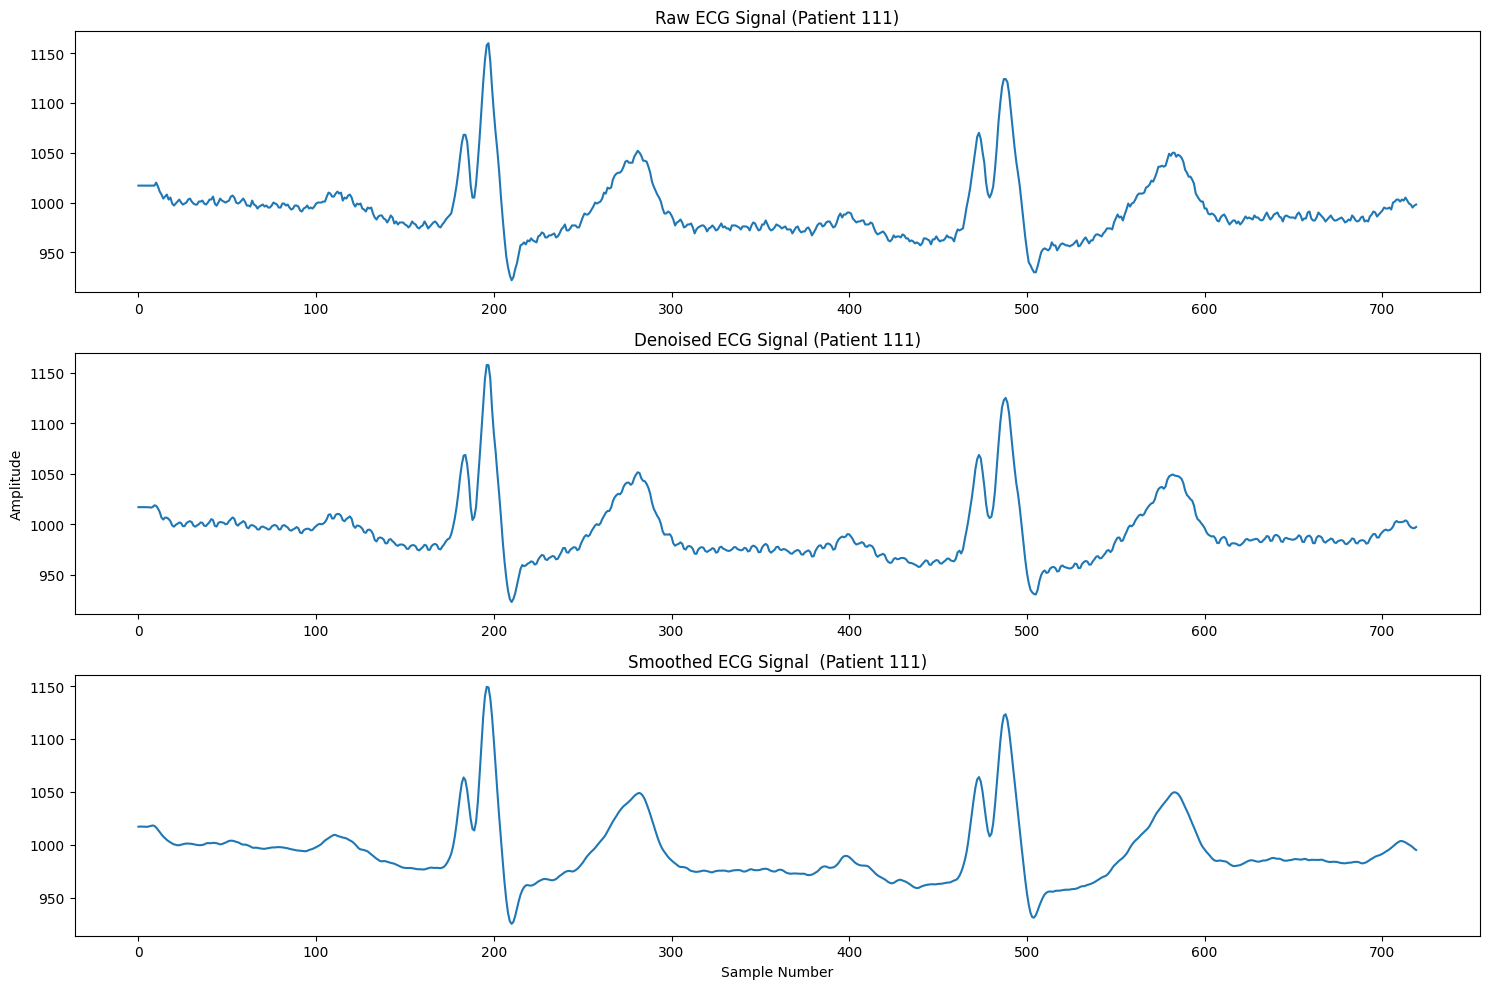

In [39]:
import matplotlib.pyplot as plt

# Assuming 'ecg_data' is your DataFrame and it contains a column with ECG signals named 'signal'
# Selecting a sample signal
sample_signal = pd.read_csv('./datasets/111.csv')
sample_signal.columns = sample_signal.columns.str.strip("'")
sample_signal = sample_signal['MLII']

# Applying noise reduction
denoised_signal = remove_baseline_wander(sample_signal)
smoothed_signal = smooth_signal(denoised_signal)

# Define the range of interest for plotting 
start, end = 0, 2 * 360 

# Plotting
plt.figure(figsize=(15, 10))

# Raw Signal
plt.subplot(3, 1, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(sample_signal[start:end])
plt.title('Raw ECG Signal (Patient 111)')

# Denoised Signal
plt.subplot(3, 1, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(denoised_signal[start:end])
plt.title('Denoised ECG Signal (Patient 111)')
plt.ylabel('Amplitude')

# Smoothed Signal
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(smoothed_signal[start:end])
plt.title('Smoothed ECG Signal  (Patient 111)')
plt.xlabel('Sample Number')

plt.tight_layout()
plt.show()

# Single Case Example

In [34]:
# Load the data
with open('./datasets/111annotations.txt', 'r') as file:
    annotations = file.readlines()
ecg_data111 = pd.read_csv('./datasets/111.csv')
annotations_df111 = parse_annotations(annotations)

# Correct the column names by removing extra quotation marks
ecg_data111.columns = ecg_data111.columns.str.strip("'")

# Sampling rate and duration for 5 minutes
sampling_rate = 360  # samples per second for MIT-BIH
duration = 5 * 60  # 5 minutes in seconds
num_samples = duration * sampling_rate

# Extract a 5-minute portion of the ECG data
start_sample = 0  # You can adjust this as needed
ecg_portion111 = ecg_data.iloc[start_sample:start_sample + num_samples].copy()
ecg_portion111['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion111['MLII'])
ecg_portion111['ECG_smoothed'] = smooth_signal(ecg_portion111['ECG_baseline_removed'])

# Filter annotations to only include those within the 5-minute window
annotations_portion111 = annotations_df111[(annotations_df111['Sample #'] >= start_sample) & 
                                     (annotations_df111['Sample #'] < start_sample + num_samples)]

# Segmentation and feature extraction on the 5-minute portion
ecg_segments111 = segment_ecg_signal(ecg_portion111['ECG_smoothed'], annotations_portion111)
ecg_features111 = extract_dwt_features(ecg_segments111)

# Feature matrix and labels for the 5-minute portion
feature_matrix111 = np.array(ecg_features111)
labels111 = annotations_portion111['Type'].values[:len(ecg_features111)]  # Ensuring labels align with the segments

print()

In [35]:
with open('datasets/109annotations.txt', 'r') as file:
    annotations_109 = file.readlines()
ecg_data_109 = pd.read_csv('datasets/109.csv')
annotations_df_109 = parse_annotations(annotations_109)

ecg_data_109.columns = ecg_data_109.columns.str.strip("'")

ecg_portion109 = ecg_data_109.iloc[start_sample:start_sample + num_samples].copy()
ecg_portion109['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion109['MLII'])
ecg_portion109['ECG_smoothed'] = smooth_signal(ecg_portion109['ECG_baseline_removed'])

annotations_portion109 = annotations_df_109[(annotations_df_109['Sample #'] >= start_sample) & 
                                     (annotations_df_109['Sample #'] < start_sample + num_samples)]

# Segmentation and feature extraction on the 5-minute portion
ecg_segments109 = segment_ecg_signal(ecg_portion109['ECG_smoothed'], annotations_portion109)
ecg_features109 = extract_dwt_features(ecg_segments109)

# Feature matrix and labels for the 5-minute portion
feature_matrix109 = np.array(ecg_features109)
labels109 = annotations_portion109['Type'].values[:len(ecg_features109)]  # Ensuring labels align with the segments

print(pd.Series(labels109).value_counts())
print()

L        424
V          6
Other      3
Name: count, dtype: int64



In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(feature_matrix111)
X_test_scaled = scaler.transform(feature_matrix109)

# SVM training with patient 111's data
svm_classifier = SVC(kernel='rbf', gamma='scale')
svm_classifier.fit(X_train_scaled, labels111)

# Prediction and evaluation
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(labels109, y_pred)

# Generate the classification report for patient 109's data
classification_rep_109 = classification_report(labels109, y_pred, labels=np.unique(labels109), target_names=[annotation_classes_map.get(label, 'Other') for label in np.unique(labels109)], zero_division=0)

print(f'Accuracy for patient 109: {accuracy}')
print(classification_rep_109)

cm = confusion_matrix(labels109, y_pred, labels=np.unique(labels109))
print()

# Calculate additional metrics from the confusion matrix if needed
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
# Precision or positive predictive value
PPV = TP / (TP + FP)
# Overall accuracy for each class
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print additional metrics
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")
print(f"Sensitivity (TPR): {TPR}")
print(f"Precision (PPV): {PPV}")
print(f"Accuracy (ACC): {ACC}\n\n\n")

Accuracy for patient 109: 0.9792147806004619
                                   precision    recall  f1-score   support

    Left bundle branch block beat       0.98      1.00      0.99       424
                            Other       0.00      0.00      0.00         3
Premature ventricular contraction       0.00      0.00      0.00         6

                         accuracy                           0.98       433
                        macro avg       0.33      0.33      0.33       433
                     weighted avg       0.96      0.98      0.97       433


True Positives (TP): [424   0   0]
False Positives (FP): [9 0 0]
False Negatives (FN): [0 3 6]
True Negatives (TN): [  0 430 427]
Sensitivity (TPR): [1. 0. 0.]
Precision (PPV): [0.97921478        nan        nan]
Accuracy (ACC): [0.97921478 0.99307159 0.98614319]





/var/folders/g4/jgjlsdxn2hd3fg2yfrd791gh0000gn/T/ipykernel_3619/2035090956.py:31: RuntimeWarning: invalid value encountered in divide
  PPV = TP / (TP + FP)
